# Лабораторная 5. Деревья решений

---

## Задание
1. [Датасет](/data/data.csv) с данными про оценки студентов инженерного и педагогического факультетов (для данного датасета нужно ввести метрику: студент успешный/неуспешный на основании грейда)
2. Отобрать случайным образом sqrt(n) признаков
3. Реализовать без использования сторонних библиотек построение дерева решений (дерево не бинарное, numpy и pandas использовать можно, использовать список списков для реализации дерева - нельзя) для решения задачи бинарной классификации
4. Провести оценку реализованного алгоритма с использованием Accuracy, precision и recall
5. Построить кривые AUC-ROC и AUC-PR (в пунктах 4 и 5 использовать библиотеки нельзя)


# Решение

In [1]:
import pandas as pd
import numpy as np

In [2]:
file_path = './data/data.csv'
data = pd.read_csv(file_path)

## Обработка данных
Отсутствующих данных в датасете нет, поэтому необходимости в их обработке нет. Переименуем колонки для удобства работы с ними

In [3]:
column_names_new = [
    "Student ID", "Student Age", "Sex", "Graduated high-school type", "Scholarship type", "Additional work", "Regular artistic or sports activity", "Do you have a partner", "Total salary if available", "Transportation to the university", "Accommodation type", "Mother's education", "Father's education", "Number of sisters/brothers", "Parental status", "Mother's occupation", "Father's occupation", "Weekly study hours", "Reading frequency (non-scientific books/journals)", "Reading frequency (scientific books/journals)", "Attendance to the seminars/conferences related to the department", "Impact of your projects/activities on your success", "Attendance to classes", "Preparation to midterm exams 1", "Preparation to midterm exams 2", "Taking notes in classes", "Listening in classes", "Discussion improves my interest and success in the course", "Flip-classroom", "Cumulative grade point average in the last semester", "Expected Cumulative grade point average in the graduation", "Course ID", "OUTPUT Grade"    
]
data.columns = column_names_new
data

,Student ID,Student Age,Sex,Graduated high-school type,Scholarship type,Additional work,Regular artistic or sports activity,Do you have a partner,Total salary if available,Transportation to the university,...,Preparation to midterm exams 1,Preparation to midterm exams 2,Taking notes in classes,Listening in classes,Discussion improves my interest and success in the course,Flip-classroom,Cumulative grade point average in the last semester,Expected Cumulative grade point average in the graduation,Course ID,OUTPUT Grade
0,STUDENT1,2,2,3,3,1,2,2,1,1,...,1,1,3,2,1,2,1,1,1,1
1,STUDENT2,2,2,3,3,1,2,2,1,1,...,1,1,3,2,3,2,2,3,1,1
2,STUDENT3,2,2,2,3,2,2,2,2,4,...,1,1,2,2,1,1,2,2,1,1
3,STUDENT4,1,1,1,3,1,2,1,2,1,...,1,2,3,2,2,1,3,2,1,1
4,STUDENT5,2,2,1,3,2,2,1,3,1,...,2,1,2,2,2,1,2,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,STUDENT141,2,1,2,3,1,1,2,1,1,...,1,1,2,1,2,1,3,3,9,5
141,STUDENT142,1,1,2,4,2,2,2,1,4,...,1,1,3,2,2,1,5,3,9,5
142,STUDENT143,1,1,1,4,2,2,2,1,1,...,1,1,3,3,2,1,4,3,9,1
143,STUDENT144,2,1,2,4,1,1,1,5,2,...,2,1,2,1,2,1,5,3,9,4


## Определение бинарной метки успешности студента
Для задачи бинарной классификации необходимо преобразовать многоклассовую сетку OUTPUT Grade в бинарную: (не)успешный студент.

In [5]:
# Удаление ненужных колонок и добавление бинарной метки успеха
def preprocess_data(data, success_threshold):
    output_label, id_label = "OUTPUT Grade", "Student ID"
    success_label = "Success"
    
    # Бинаризация метки
    output_column = data[output_label]
    success_column = output_column.apply(lambda x: 1 if x >= success_threshold else 0)
    data[success_label] = success_column
    
    # Удаление ненужных колонок
    data = data.drop(columns=[output_label, id_label])
    return data, success_label

# Случайным образом отберём sqrt(n) признаков:
def select_feature_sqrt(data, success_label, random_seed=1):
    sqrt_n = int(np.sqrt(len(data.columns) - 1)) # -1, так как здесь добавлено "Success"
    np.random.seed(random_seed)
    random_columns = np.random.choice(data.columns.drop(success_label), sqrt_n, replace=False)
    selected_columns = list(random_columns) + [success_label]
    data = data[selected_columns]
    print(f"Выбранные колонны: {sqrt_n} свойств\n{random_columns}")
    return data

## Дерево решений
Построение дерева решений для решения задачи бинарной классификации без использования сторонних библиотек.
Реализуем дерево решений по алгоритму C4.5, который использует отношение прироста информации (Information Gain Ratio) для выбора оптимальных признаков. 

In [30]:
class DecisionTreeNode:
    def __init__(self, attribute=None, branches=None, is_leaf=False, prediction=None, class_counts=None):
        self.attribute = attribute        # Атрибут для разбиения
        self.branches = branches or {}    # Дочерние узлы
        self.is_leaf = is_leaf            # Является ли узел листом
        self.prediction = prediction      # Предсказание класса (для листа)
        self.class_counts = class_counts  # Количество классов (для вероятностей)
        
    def predict_instance(self, instance):
        if self.is_leaf:
            return self.prediction
        attribute_value = instance.get(self.attribute)
        if attribute_value in self.branches:
            return self.branches[attribute_value].predict_instance(instance)
        else:
            # Если значение атрибута не встречалось при обучении, возвращаем наиболее частый класс
            return self.prediction
        
    def predict_proba_instance(self, instance):
        if self.is_leaf:
            total = sum(self.class_counts.values())
            proba = self.class_counts.get(1, 0) / (total + 1e-9)
            return proba
        attribute_value = instance.get(self.attribute)
        if attribute_value in self.branches:
            return self.branches[attribute_value].predict_proba_instance(instance)
        else:
            # Если значение атрибута не встречалось при обучении, возвращаем вероятности наиболее частого класса
            total = sum(self.class_counts.values())
            proba = self.class_counts.get(1, 0) / (total + 1e-9)
            return proba
        
class DecisionTree:
    def __init__(self):
        self.root = None
        
    def entropy(self, y):
        class_counts = y.value_counts()
        probabilities = class_counts / len(y)
        return -sum(probabilities * np.log2(probabilities + 1e-9)) # Добавляем 1e-9 для избежания log(0)
    
    def information_gain_ratio(self, x, y, attribute):
        # Энтропия до разбиения
        entropy_before = self.entropy(y)
        
        # Группировка по значениям атрибута
        values, counts = np.unique(x[attribute], return_counts=True)
        weighted_entropy = 0
        split_info = 0
        for v, count in zip(values, counts):
            subset_y = y[x[attribute] == v]
            weighted_entropy += (count / len(y)) * self.entropy(subset_y)
            split_info -= (count / len(y)) * np.log2(count / len(y) + 1e-9)
        
        info_gain = entropy_before - weighted_entropy
        gain_ratio = info_gain / (split_info + 1e-9)
        return gain_ratio
    
    def build_tree_recursive(self, x, y, attributes, default_class=None):
        if len(y) == 0:
            return DecisionTreeNode(is_leaf=True, prediction=default_class)
        elif len(y.unique()) == 1:
            return DecisionTreeNode(is_leaf=True, prediction=y.iloc[0], class_counts=y.value_counts().to_dict())
        elif len(attributes) == 0:
            majority_class = y.mode()[0]
            class_counts = y.value_counts().to_dict()
            return DecisionTreeNode(is_leaf=True, prediction=majority_class, class_counts=class_counts)
        else:
            default_class = y.mode()[0]
            
            # Выбор атрибута с максимальным Gain Ratio
            gain_ratios = {attr: self.information_gain_ratio(x, y, attr) for attr in attributes}
            best_attr = max(gain_ratios, key=gain_ratios.get)
            
            # Создание узла
            class_counts = y.value_counts().to_dict()
            tree = DecisionTreeNode(attribute=best_attr, prediction=default_class, class_counts=class_counts)
            
            # Разбиение по значениям лучшего атрибута
            for attr_val in np.unique(x[best_attr]):
                subset_x = x[x[best_attr] == attr_val].drop(columns=[best_attr])
                subset_y = y[x[best_attr] == attr_val]
                subtree = self.build_tree_recursive(subset_x, subset_y, [attr for attr in attributes if attr != best_attr], default_class=default_class)
                tree.branches[attr_val] = subtree
            return tree
        
    def build_tree(self, x, y):
        attributes = list(x.columns)
        self.root = self.build_tree_recursive(x, y, attributes)
        print("Дерево решений построено.")
        
    def predict_instance(self, instance):
        return self.root.predict_instance(instance)
    
    def predict_proba_instance(self, instance):
        return self.root.predict_proba_instance(instance)
    
    def predict(self, x):
        return x.apply(self.predict_instance, axis=1).values
    
    def predict_proba(self, x):
        return x.apply(self.predict_proba_instance, axis=1).values
    
    def compute_metrics(self, y_true, y_pred):
        TP = np.sum((y_true == 1) & (y_pred == 1))
        TN = np.sum((y_true == 0) & (y_pred == 0))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        FN = np.sum((y_true == 1) & (y_pred == 0))
        
        confusion_matrix = np.array([[TP, TN], [FP, FN]])
        accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-9)
        precision = TP / (TP + FP + 1e-9)
        recall = TP / (TP + FN + 1e-9)
        
        return confusion_matrix, accuracy, precision, recall
    
    def calculate_auc(self, y_true, y_scores, curve_type='ROC'):
        # Сортируем по убыванию вероятностей
        desc_score_indices = np.argsort(-y_scores)
        y_true = y_true[desc_score_indices]
        y_scores = y_scores[desc_score_indices]
        
        # Уникальные значения
        distinct_value_indices = np.where(np.diff(y_scores))[0]
        threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]
        
        tps = np.cumsum(y_true)[threshold_idxs]
        fps = 1 + threshold_idxs - tps
        
        tps = np.r_[0, tps]
        fps = np.r_[0, fps]
        
        if curve_type == 'ROC':
            fpr = fps / fps[-1] if fps[-1] != 0 else fps
            tpr = tps / tps[-1] if tps[-1] != 0 else tps
            auc = np.trapz(tpr, fpr)
            return fpr, tpr, auc
        elif curve_type == 'PR':
            precision = tps / (tps + fps + 1e-9)
            recall = tps / tps[-1] if tps[-1] != 0 else tps
            auc = np.trapz(precision, recall)
            return recall, precision, auc
        else:
            raise ValueError("curve_type должен быть 'ROC' или 'PR'")
    
    def calculate_auc_metrics(self, y_true, y_scores):
        # Расчёт AUC-ROC
        fpr, tpr, auc_roc = self.calculate_auc(y_true, y_scores, curve_type='ROC')
        
        # Расчёт AUC-PR
        recall, precision, auc_pr = self.calculate_auc(y_true, y_scores, curve_type='PR')
        return (fpr, tpr, auc_roc), (recall, precision, auc_pr)
    def __str__(self):
        lines = []
        self._str_recursive(self.root, lines, "")
        return "\n".join(lines)

    def _str_recursive(self, node, lines, pref):
        if node.is_leaf:
            lines.append(f"{pref}Leaf: {node.prediction} (Counts: {node.class_counts})")
        else:
            lines.append(f"{pref}Attribute: {node.attribute}")
            for i, (value, subtree) in enumerate(node.branches.items()):
                connector = "├─ " if i < len(node.branches) - 1 else "└─ "
                lines.append(f"{pref} {connector}{value} -> ")
                new_pref = pref + " │  " if i < len(node.branches) - 1 else "   "
                self._str_recursive(subtree, lines, new_pref)

## Разделение данных на обучающую и тестовую выборки

In [27]:
def train_test_split_custom(x, y, test_size=0.2, random_seed=1):
    if random_seed:
        np.random.seed(random_seed)
    indices = np.random.permutation(len(x))
    test_size = int(len(x) * test_size)
    
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]
    
    return x.iloc[train_indices], x.iloc[test_indices], y.iloc[train_indices], y.iloc[test_indices]

In [31]:
# Определение порогов
thresholds = range(1, 7)
RANDOM_SEED = 106

# Случайным образом отберем sqrt(n) признаков один раз для всех порогов
preprocessed_data, success_label = preprocess_data(data, success_threshold=2) # Временный порог
selected_data = select_feature_sqrt(preprocessed_data, success_label, random_seed=RANDOM_SEED)

# Сохраним выбранные признаки
selected_features = selected_data.columns.drop(success_label)
# Хранение результатов
results = {}

for t in thresholds:
    print(f"\nОбработка порога: {t}")
    # Бинаризация меток с текущим порогом
    binarized_data, _ = preprocess_data(data, success_threshold=t)
    binarized_data = binarized_data[selected_features.tolist() + [success_label]]
    
    # Разделение данных
    x = binarized_data.drop(columns=[success_label])
    y = binarized_data[success_label]
    x_train, x_test, y_train, y_test = train_test_split_custom(x, y, test_size=0.2, random_seed=RANDOM_SEED)
    
    print(f"Размер обучающей выборки: {x_train.shape[0]}")
    print(f"Размер тестовой выборки: {x_test.shape[0]}")
    
    # Обучение дерева
    tree = DecisionTree()
    tree.build_tree(x_train, y_train)
    
    # Предсказание
    y_pred = tree.predict(x_test)
    y_proba = tree.predict_proba(x_test)
    
    # Вычисление метрики
    confusion_matrix, accuracy, precision, recall = tree.compute_metrics(y_test.values, y_pred)
    
    # Вычисление AUC-ROC и AUC-PR
    auc_roc_metrics, auc_pr_metrics = tree.calculate_auc_metrics(y_test.values, y_proba)
    fpr, tpr, auc_roc = auc_roc_metrics
    recall_vals, precision_vals, auc_pr = auc_pr_metrics
    
    # Сохранение результатов
    results[t] = {
        'confusion_matrix': confusion_matrix,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'fpr': fpr,
        'tpr': tpr,
        'auc_roc': auc_roc,
        'recall_vals': recall_vals,
        'precision_vals': precision_vals,
        'auc_pr': auc_pr,
        'tree': tree
    }
    
    # Вывод метрик
    print(f"Confusion Matrix:\n{confusion_matrix}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"AUC-PR: {auc_pr:.4f}")
    
    print(f"Дерево для порога {t}:\n{tree}")

Выбранные колонны: 5 свойств
['Taking notes in classes' "Father's occupation" 'Course ID'
 'Transportation to the university' 'Student Age']

Обработка порога: 1
Размер обучающей выборки: 116
Размер тестовой выборки: 29
Дерево решений построено.
Confusion Matrix:
[[26  0]
 [ 2  1]]
Accuracy: 0.8966
Precision: 0.9286
Recall: 0.9630
AUC-ROC: 0.8519
AUC-PR: 0.8407
Дерево для порога 1:
Attribute: Transportation to the university
 ├─ 1 -> 
 │  Attribute: Father's occupation
 │   ├─ 1 -> 
 │   │  Leaf: 1 (Counts: {1: 19})
 │   ├─ 2 -> 
 │   │  Attribute: Taking notes in classes
 │   │   ├─ 2 -> 
 │   │   │  Attribute: Course ID
 │   │   │   ├─ 1 -> 
 │   │   │   │  Leaf: 0 (Counts: {0: 1})
 │   │   │   ├─ 2 -> 
 │   │   │   │  Leaf: 1 (Counts: {1: 1})
 │   │   │   └─ 3 -> 
   Leaf: 1 (Counts: {1: 1})
 │   │   └─ 3 -> 
   Leaf: 1 (Counts: {1: 6})
 │   ├─ 3 -> 
 │   │  Leaf: 1 (Counts: {1: 20})
 │   ├─ 4 -> 
 │   │  Leaf: 1 (Counts: {1: 21})
 │   └─ 5 -> 
   Leaf: 1 (Counts: {1: 8})
 ├─ 2 -> 


## Построение кривых AUC-ROC и AUC-PR

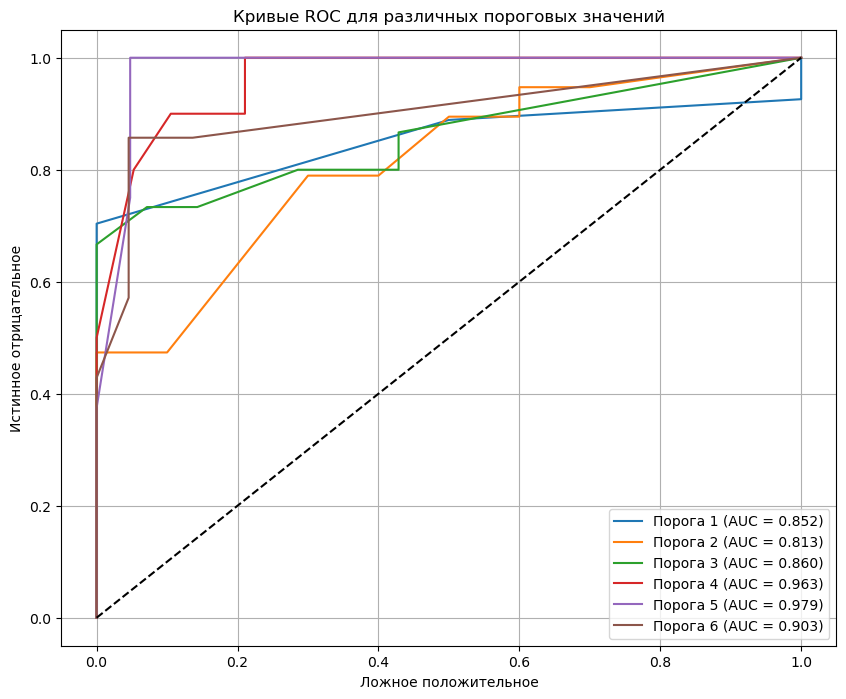

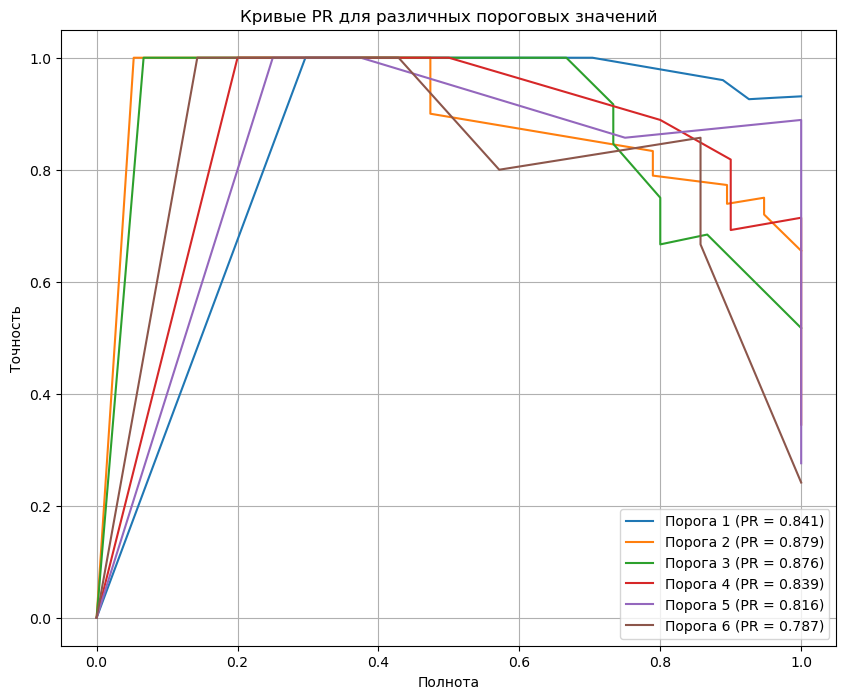

In [32]:
import matplotlib.pyplot as plt

# Построение кривых AUC-ROC
plt.figure(figsize=(10, 8))
for t in thresholds:
    plt.plot(results[t]['fpr'], results[t]['tpr'], label=f'Порога {t} (AUC = {results[t]['auc_roc']:.3f})')
plt.plot([0, 1], [0, 1], 'k--') # Диагональ
plt.xlabel("Ложное положительное")
plt.ylabel("Истинное отрицательное")
plt.title("Кривые ROC для различных пороговых значений")
plt.legend()
plt.grid(True)
plt.show()

# Построение кривых AUC-PR
plt.figure(figsize=(10, 8))
for t in thresholds:
    plt.plot(results[t]['recall_vals'], results[t]['precision_vals'], label=f'Порога {t} (PR = {results[t]['auc_pr']:.3f})')
plt.xlabel("Полнота")
plt.ylabel("Точность")
plt.title("Кривые PR для различных пороговых значений")
plt.legend()
plt.grid(True)
plt.show()

## Таблица с метриками для всех порогов

In [34]:
metrics_table = pd.DataFrame(columns=['Threshold', 'Accuracy', 'Precision', 'Recall', 'AUC-ROC', "AUC-PR"])

for t in thresholds:
    row = pd.DataFrame([{
        'Threshold': t,
        'Accuracy': results[t]['accuracy'],
        'Precision': results[t]['precision'],
        'Recall': results[t]['recall'],
        'AUC-ROC': results[t]['auc_roc'],
        'AUC-PR': results[t]['auc_pr']
    }])
    metrics_table = pd.concat([metrics_table if not metrics_table.empty else None, row], ignore_index=True)

print("Метрики для различных порогов:")
print(metrics_table)

print(sum(metrics_table['AUC-ROC']) / len(thresholds))

Метрики для различных порогов:
   Threshold  Accuracy  Precision    Recall   AUC-ROC    AUC-PR
0          1  0.896552   0.928571  0.962963  0.851852  0.840741
1          2  0.758621   0.750000  0.947368  0.813158  0.878650
2          3  0.793103   0.846154  0.733333  0.859524  0.875553
3          4  0.896552   0.818182  0.900000  0.963158  0.839017
4          5  0.965517   0.888889  1.000000  0.979167  0.816468
5          6  0.931034   0.857143  0.857143  0.902597  0.787309
0.8949092533522358
